# Comparison among the different analysis types

In [ ]:
import toml
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from app.task import load_data, compute_low_expression_percs, get_output_df, get_output_list

# Loading parameters from TOML file
toml_file = "pyproject.toml"
config = toml.load(toml_file)
params = config["tool"]["flwr"]["app"]["config"]
num_partitions = config["tool"]["flwr"]["federations"]["local-simulation"]["options"]["num-supernodes"]


## Federated analysis

Here we read the results of the FL process and show the results.

In [3]:
# Read the output of the federated analysis
ndarrays = np.load("output.npy", allow_pickle=True)

# Identify weakly expressed genes
df_out = get_output_df(ndarrays)
list_out = get_output_list(df_out, params["expr_perc"])

# Print results
print("\nPercentage of individuals where gene is expressed less than threshold:\n", df_out.to_string(index=False), "\n")
print("\nWeakly expressed genes:", list_out)



Percentage of individuals where gene is expressed less than threshold:
  Gene_1  Gene_2  Gene_3  Gene_4  Gene_5  Gene_6
   87.0    37.0     0.0    75.0    68.0    77.0 


Weakly expressed genes: ['Gene_1', 'Gene_4', 'Gene_6']


## Centralized analysis

Here, we aggregate the datasets from the different clients participating in the FL process and perform the weak-expression analysis in a centralized manner. Note that the results are <b>identical</b> to those obtained through FL. However, it's important to note that this approach would not be feasible in a real-world scenario where only FL is authorized.

In [ ]:
# Concatenate all partitions into a single dataset
all_partitions = []
for i in range(num_partitions):  
    data = load_data(i, num_partitions, params["num_individuals"], 
                     num_genes = params["num_genes"], seed_value = params["seed_value"])
    data["Source"] = f"Client {i + 1}"
    all_partitions.append(data)
merged_dataset = pd.concat(all_partitions)
#print(merged_dataset.head())

# Identify weakly expressed genes
percs = compute_low_expression_percs(merged_dataset.iloc[:,:-1], params["expr_thr"])
df_out = get_output_df([percs])
list_out = get_output_list(df_out, params["expr_perc"])

# Print results
print("\nPercentage of samples where gene is expressed less than threshold:\n", df_out.to_string(index=False), "\n")
print("\nWeakly expressed genes:", list_out)



Percentage of samples where gene is expressed less than threshold:
  Gene_1  Gene_2  Gene_3  Gene_4  Gene_5  Gene_6
   90.0    48.0     0.0    84.0    63.0    83.0 


Weakly expressed genes: ['Gene_1', 'Gene_4', 'Gene_6']


## Local analysis

Here, we present the results each client would obtain by analyzing their dataset independently. Notably, using the default seed value from the configuration file, the set of weakly expressed genes identified by a single client does not necessarily align with the set of weakly expressed genes resulting from the federated or centralized analysis. For example, in the local analysis, <b>Client 1</b> identifies a larger set of weakly expressed genes, whereas <b>Client 2</b> identifies a smaller set.

In [ ]:
for i in range(num_partitions):
    # Load a partition
    data = load_data(i, num_partitions, params["num_individuals"], 
                     num_genes = params["num_genes"], seed_value = params["seed_value"])

    # Identify weakly expressed genes
    percs = compute_low_expression_percs(data, params["expr_thr"])
    df_out = get_output_df([percs])
    list_out = get_output_list(df_out, params["expr_perc"])
    
    # Print results
    print("--- Client", i+1, "---")
    print("\nPercentage of samples where gene is expressed less than threshold:\n", df_out.to_string(index=False), "\n")
    print("\nWeakly expressed genes:", list_out, "\n")

--- Client 1 ---

Percentage of samples where gene is expressed less than threshold:
  Gene_1  Gene_2  Gene_3  Gene_4  Gene_5  Gene_6
   95.0    75.0     0.0    85.0    45.0    90.0 


Weakly expressed genes: ['Gene_1', 'Gene_2', 'Gene_4', 'Gene_6'] 

--- Client 2 ---

Percentage of samples where gene is expressed less than threshold:
  Gene_1  Gene_2  Gene_3  Gene_4  Gene_5  Gene_6
   90.0    45.0     0.0    70.0    60.0    65.0 


Weakly expressed genes: ['Gene_1'] 

--- Client 3 ---

Percentage of samples where gene is expressed less than threshold:
  Gene_1  Gene_2  Gene_3  Gene_4  Gene_5  Gene_6
   95.0    40.0     0.0    85.0    65.0    85.0 


Weakly expressed genes: ['Gene_1', 'Gene_4', 'Gene_6'] 

--- Client 4 ---

Percentage of samples where gene is expressed less than threshold:
  Gene_1  Gene_2  Gene_3  Gene_4  Gene_5  Gene_6
   85.0    50.0     0.0   100.0    70.0    85.0 


Weakly expressed genes: ['Gene_1', 'Gene_4', 'Gene_6'] 

--- Client 5 ---

Percentage of samples wh

## Visual comparison for local and centralized analyses

The following plot provides an overview of gene expression levels across the different local client datasets as well as the overall dataset. Notice, for example, how, with the default seed value used in the configuration file, the expression levels of <b>Gene_2</b> are lower for <b>Client 1</b> compared to the overall dataset. This makes <b>Gene_2</b> locally weakly expressed for <b>Client 1</b>, but not weakly expressed overall.

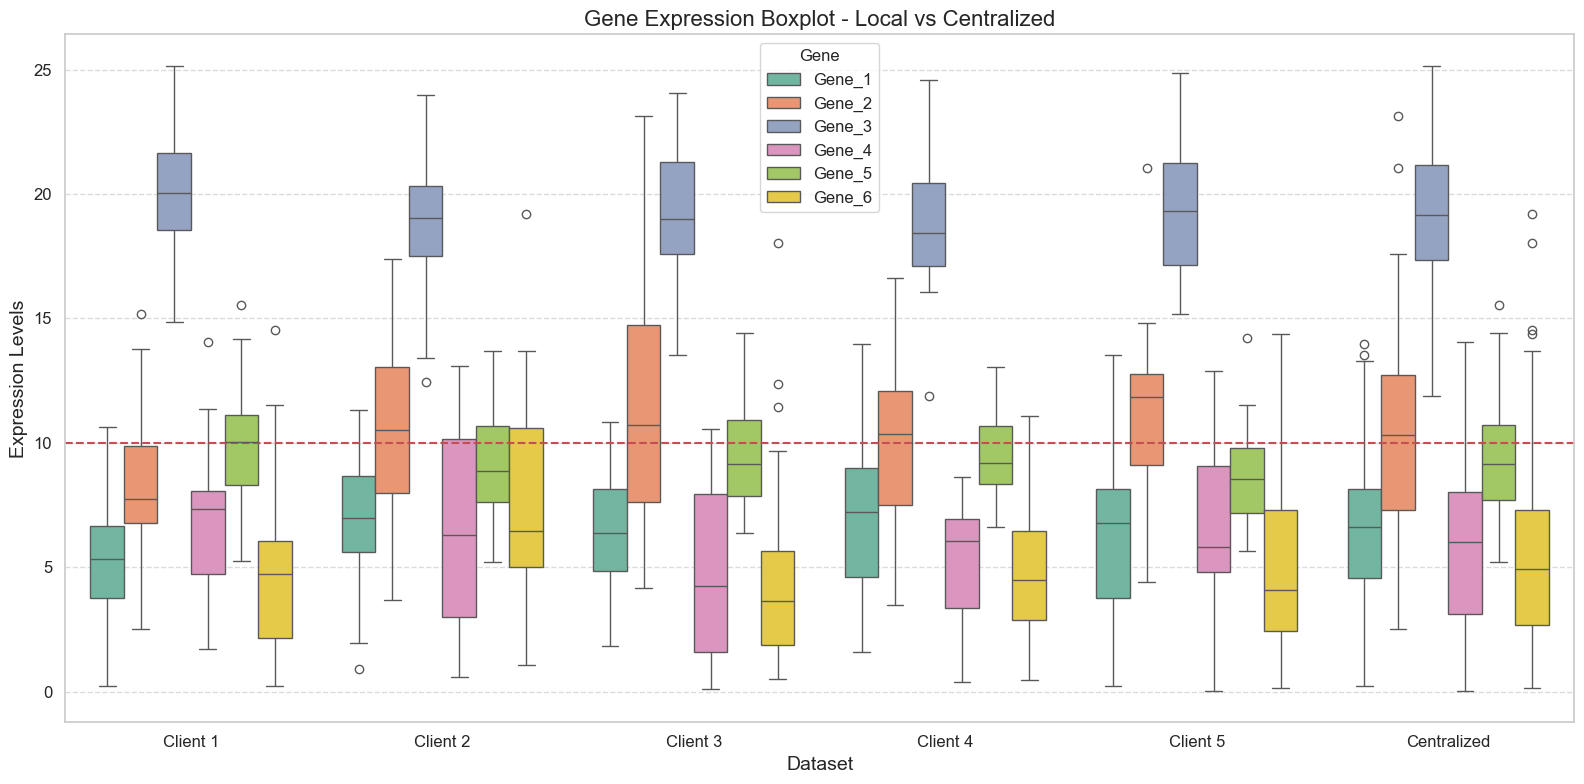

In [6]:
# Create dataset for visualization
gene_data_loc = merged_dataset.melt(id_vars=["Source"], value_name="Expression", var_name="Gene")
gene_data_centr = gene_data_loc.assign(Source="Centralized")
gene_data = pd.concat([gene_data_loc, gene_data_centr], ignore_index=True)

# Create boxplot
plt.figure(figsize=(16, 8))
sns.set_theme(style="whitegrid")
boxplot = sns.boxplot(x="Source", y="Expression", hue="Gene", data=gene_data, palette="Set2")

# Add horizontal line at reference expression value
plt.axhline(y=params["expr_thr"], color='r', linestyle='--')

# Customize plot
plt.xlabel("Dataset", fontsize=14)
plt.ylabel("Expression Levels", fontsize=14)
plt.title("Gene Expression Boxplot - Local vs Centralized", fontsize=16)
plt.xticks(ha="center", fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title="Gene", fontsize=12)
plt.grid(True, axis='y', linestyle='--', alpha=0.7)

# Show plot
plt.tight_layout()
plt.show()